In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [17]:
TRAIN_SZ = 0.7
VAL_SZ = 0.15
TEST_SZ = 0.15
FOLD_SZ = 4
LAGS_SZ = 8
H_FORECAST = 1
L_RATE = 0.005

In [18]:
#Consumption dataframe
df_consumo = pd.read_csv(r"consumo_energia.csv")
df_consumo['date'] = pd.to_datetime(df_consumo['din_instante'])
df_consumo.set_index('date', inplace=True)
df_consumo.sort_index(inplace=True)
df_consumo.drop(['id_subsistema'],axis=1)

#Generation dataframe
df_geracao = pd.read_csv(r"geracao_energia.csv")
df_geracao['date'] = pd.to_datetime(df_geracao['index'])
df_geracao.set_index('date', inplace=True)
df_geracao['month'] = df_geracao.index.month
df_geracao['weekday'] = df_geracao.index.weekday
df_geracao.sort_index(inplace=True)
merged_df = pd.merge(df_geracao, df_consumo, on='date')

merged_df

,index,val_geracao,id_subsistema_x,nom_subsistema_x,id_estado,cod_modalidadeoperacao,id_ons,nom_tipousina,month,weekday,din_instante,id_subsistema_y,nom_subsistema_y,din_instante.1,val_cargaenergiamwmed
date,,,,,,,,,,,,,,,
2020-01-01,2020-01-01,116387.442,S,SUL,PR,TIPO I,PRGJR,HIDROELÉTRICA,1,2,2020-01-01,S,Sul,2020-01-01,9969.994875
2020-01-02,2020-01-02,163275.410,S,SUL,PR,TIPO I,PRUHSS,HIDROELÉTRICA,1,3,2020-01-02,S,Sul,2020-01-02,11190.429417
2020-01-03,2020-01-03,147938.013,S,SUL,PR,TIPO I,PRSCL,HIDROELÉTRICA,1,4,2020-01-03,S,Sul,2020-01-03,11121.447042
2020-01-04,2020-01-04,138267.427,S,SUL,PR,TIPO I,PRSCL,HIDROELÉTRICA,1,5,2020-01-04,S,Sul,2020-01-04,10443.865958
2020-01-05,2020-01-05,116522.452,S,SUL,PR,TIPO I,PRGNB,HIDROELÉTRICA,1,6,2020-01-05,S,Sul,2020-01-05,9790.935042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,2024-12-27,283163.017,S,SUL,PR,Pequenas Usinas (Tipo III),PQU_PRPR_E,EOLIELÉTRICA,12,4,2024-12-27,S,Sul,2024-12-27,12800.938792
2024-12-28,2024-12-28,268000.832,S,SUL,PR,Pequenas Usinas (Tipo III),PQU_PRPR_E,EOLIELÉTRICA,12,5,2024-12-28,S,Sul,2024-12-28,12649.711875
2024-12-29,2024-12-29,269194.124,S,SUL,PR,Pequenas Usinas (Tipo III),PQU_PRPR_E,EOLIELÉTRICA,12,6,2024-12-29,S,Sul,2024-12-29,11543.374792


In [19]:
df = merged_df

# Seleção de colunas e normalização
df = df[['index', 'month', 'weekday', 'val_geracao', 'val_cargaenergiamwmed']]

#Divind Train and Test, the cross validation will be applied to the train set
train_set = df[:1516]
test_set = df[1516:] # will be used at the end of each model training and at the end for the meta model validation

#Z-Score Standarization
scaler = StandardScaler()
train_set['val_geracao_norm'] = scaler.fit_transform(train_set[['val_geracao']])
train_set['val_cargaenergiamwmed_norm'] = scaler.fit_transform(train_set[['val_cargaenergiamwmed']])
train_set['month_norm'] = scaler.fit_transform(train_set[['month']])
train_set['weekday_norm'] = scaler.fit_transform(train_set[['weekday']])

#defininf dependent and idependent variables
predictors = train_set[['month_norm','weekday_norm','val_geracao_norm','val_cargaenergiamwmed_norm']]
predicted = predictors[['val_geracao_norm']]


#Creating sequences
X, y = [], []
data_np = predictors.to_numpy()
pred_np = predicted.to_numpy()
for i in range(len(data_np) - LAGS_SZ - H_FORECAST + 1):
    X.append(data_np[i:i+LAGS_SZ])
    y.append(pred_np[i+LAGS_SZ:i+LAGS_SZ+H_FORECAST])

X = np.array(X)
y = np.array(y)
# KFold sobre os dados de treino/validação
kf = KFold(n_splits=FOLD_SZ, shuffle=False)

X_train_folds = []
X_test_folds = []
y_train_folds = []
y_test_folds = []

for train_index, test_index in kf.split(X):
    X_train_fold = X[train_index]
    X_test_fold = X[test_index]
    y_train_fold = y[train_index]
    y_test_fold = y[test_index]

    X_train_folds.append(X_train_fold)
    X_test_folds.append(X_test_fold)
    y_train_folds.append(y_train_fold)
    y_test_folds.append(y_test_fold)

C:\Users\mateu\AppData\Local\Temp\ipykernel_6572\1385390501.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['val_geracao_norm'] = scaler.fit_transform(train_set[['val_geracao']])
C:\Users\mateu\AppData\Local\Temp\ipykernel_6572\1385390501.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['val_cargaenergiamwmed_norm'] = scaler.fit_transform(train_set[['val_cargaenergiamwmed']])
C:\Users\mateu\AppData\Local\Temp\ipykernel_6572\1385390501.py:14: SettingWithCopyWarning: 
A value is t

Text(0.5, 1.0, 'Generation PACF Plot')

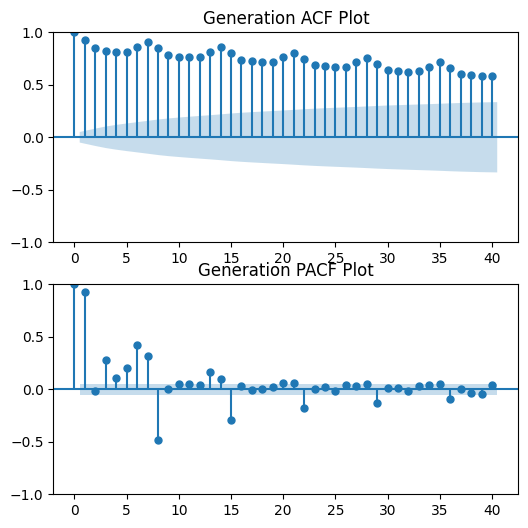

In [20]:
#Generation and Consumptionm ACF and PACF
fig, ax,  = plt.subplots(2, 1, figsize=(6, 6))
plot_acf(predicted, ax=ax[0], lags=40)
ax[0].set_title("Generation ACF Plot")
plot_pacf(predicted, ax=ax[1], lags=40, method='ywm')
ax[1].set_title("Generation PACF Plot")

In [21]:
#Models definition

#Buildintg the LSTM architecture
def build_lstm(input_shape, learning_rate):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
    return model
    
#Buildintg the GRU architecture
def build_gru(input_shape, learning_rate):
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
    return model

#Buildintg the XGBoost architecture
def build_xgboost():
    model = xgb.XGBRegressor(objective='reg:squarederror',
                             colsample_bytree=0.4603, 
                             gamma=0.0468, 
                             learning_rate=0.005, 
                             max_depth=3, 
                             min_child_weight=1.7817, 
                             n_estimators=2200,
                             reg_alpha=0.4640, 
                             reg_lambda=0.8571,
                             subsample=0.5213, 
                             verbosity=1,
                             random_state =7, 
                             nthread = -1)
    return model

#Building a CNN architecture
def build_cnn(input_shape, learning_rate):
    model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
    return model

# ------------------------ Meta Learner ----------------------- #

def build_rf():
    return RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)


In [22]:
#list of models
xgb_trained  = []
cnn_trained  = []
gru_trained  = []
lstm_trained = []

# Prediction that are composing the meta learner training set
xgb_preds  = []
cnn_preds  = []
gru_preds  = []
lstm_preds = []

In [23]:
#Eval function
def print_metrics(y_true, y_pred, model_name, fold):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f'\n📊 Fold {fold} - {model_name}:\n'
          f'   MSE:  {mse:.4f}\n'
          f'   RMSE: {rmse:.4f}\n'
          f'   MAPE: {mape:.4f}\n')

fold X 1 de treino: (1131, 8, 4) e fold 1 X de teste: (377, 8, 4)
fold y 1 de treino: (1131, 1, 1) e fold 1 y de teste: (377, 1, 1)
 -------------------------------------- Treinando o fold 1 da rede LSTM -------------------------------------- 
Epoch 1/50


c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2989 - root_mean_squared_error: 0.5416
Epoch 1: saving model to models/lstm_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2968 - root_mean_squared_error: 0.5397
Epoch 2/50
29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1366 - root_mean_squared_error: 0.3693
Epoch 2: saving model to models/lstm_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1341 - root_mean_squared_error: 0.3659
Epoch 3/50
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1016 - root_mean_squared_error: 0.3186
Epoch 3: saving model to models/lstm_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0980 - root_mean_squared_error: 0.3129
Epoch 4/50
27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0812 - root_mean_squared_error: 0.2849
Epoch 4: saving model to models/lstm_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0805 - root_mean_squared_error: 0.2836
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6m

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3079 - root_mean_squared_error: 0.5488
Epoch 1: saving model to models/cnn_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2885 - root_mean_squared_error: 0.5307
Epoch 2/50
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1098 - root_mean_squared_error: 0.3313
Epoch 2: saving model to models/cnn_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1099 - root_mean_squared_error: 0.3315
Epoch 3/50
29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1088 - root_mean_squared_error: 0.3298
Epoch 3: saving model to models/cnn_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1090 - root_mean_squared_error: 0.3302
Epoch 4/50
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1003 - root_mean_squared_error: 0.3163
Epoch 4: saving model to models/cnn_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1005 - root_mean_squared_error: 0.3166
Epoch 5/50
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3681 - root_mean_squared_error: 0.5909
Epoch 1: saving model to models/lstm_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3379 - root_mean_squared_error: 0.5654
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1036 - root_mean_squared_error: 0.3215
Epoch 2: saving model to models/lstm_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1038 - root_mean_squared_error: 0.3218
Epoch 3/50
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1082 - root_mean_squared_error: 0.3287
Epoch 3: saving model to models/lstm_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1064 - root_mean_squared_error: 0.3259
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0767 - root_mean_squared_error: 0.2769
Epoch 4: saving model to models/lstm_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0768 - root_mean_squared_error: 0.2770
Epoch 5/50
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4069 - root_mean_squared_error: 0.6285
Epoch 1: saving model to models/cnn_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3764 - root_mean_squared_error: 0.6033
Epoch 2/50
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1130 - root_mean_squared_error: 0.3361
Epoch 2: saving model to models/cnn_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1123 - root_mean_squared_error: 0.3350
Epoch 3/50
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0953 - root_mean_squared_error: 0.3086
Epoch 3: saving model to models/cnn_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0951 - root_mean_squared_error: 0.3084
Epoch 4/50
27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0956 - root_mean_squared_error: 0.3089
Epoch 4: saving model to models/cnn_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0933 - root_mean_squared_error: 0.3052
Epoch 5/50
29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4803 - root_mean_squared_error: 0.6764
Epoch 1: saving model to models/lstm_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4094 - root_mean_squared_error: 0.6229
Epoch 2/50
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1443 - root_mean_squared_error: 0.3798
Epoch 2: saving model to models/lstm_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1407 - root_mean_squared_error: 0.3750
Epoch 3/50
27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1095 - root_mean_squared_error: 0.3306
Epoch 3: saving model to models/lstm_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1085 - root_mean_squared_error: 0.3292
Epoch 4/50
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0925 - root_mean_squared_error: 0.3038
Epoch 4: saving model to models/lstm_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0913 - root_mean_squared_error: 0.3019
Epoch 5/50
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4469 - root_mean_squared_error: 0.6556   
Epoch 1: saving model to models/cnn_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3657 - root_mean_squared_error: 0.5911
Epoch 2/50
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1115 - root_mean_squared_error: 0.3339
Epoch 2: saving model to models/cnn_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1117 - root_mean_squared_error: 0.3341
Epoch 3/50
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1080 - root_mean_squared_error: 0.3284 
Epoch 3: saving model to models/cnn_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1049 - root_mean_squared_error: 0.3237
Epoch 4/50
18/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0960 - root_mean_squared_error: 0.3094 
Epoch 4: saving model to models/cnn_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0934 - root_mean_squared_error: 0.3053
Epoch 5/50
19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5158 - root_mean_squared_error: 0.7013
Epoch 1: saving model to models/lstm_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4338 - root_mean_squared_error: 0.6401
Epoch 2/50
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1408 - root_mean_squared_error: 0.3749
Epoch 2: saving model to models/lstm_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1353 - root_mean_squared_error: 0.3674
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1015 - root_mean_squared_error: 0.3183
Epoch 3: saving model to models/lstm_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1015 - root_mean_squared_error: 0.3183
Epoch 4/50
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0908 - root_mean_squared_error: 0.3008
Epoch 4: saving model to models/lstm_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0880 - root_mean_squared_error: 0.2962
Epoch 5/50
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3738 - root_mean_squared_error: 0.5976
Epoch 1: saving model to models/cnn_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3351 - root_mean_squared_error: 0.5650
Epoch 2/50
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1108 - root_mean_squared_error: 0.3321
Epoch 2: saving model to models/cnn_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1099 - root_mean_squared_error: 0.3308
Epoch 3/50
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0877 - root_mean_squared_error: 0.2960
Epoch 3: saving model to models/cnn_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0877 - root_mean_squared_error: 0.2960
Epoch 4/50
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0821 - root_mean_squared_error: 0.2863
Epoch 4: saving model to models/cnn_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0820 - root_mean_squared_error: 0.2862
Epoch 5/50
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

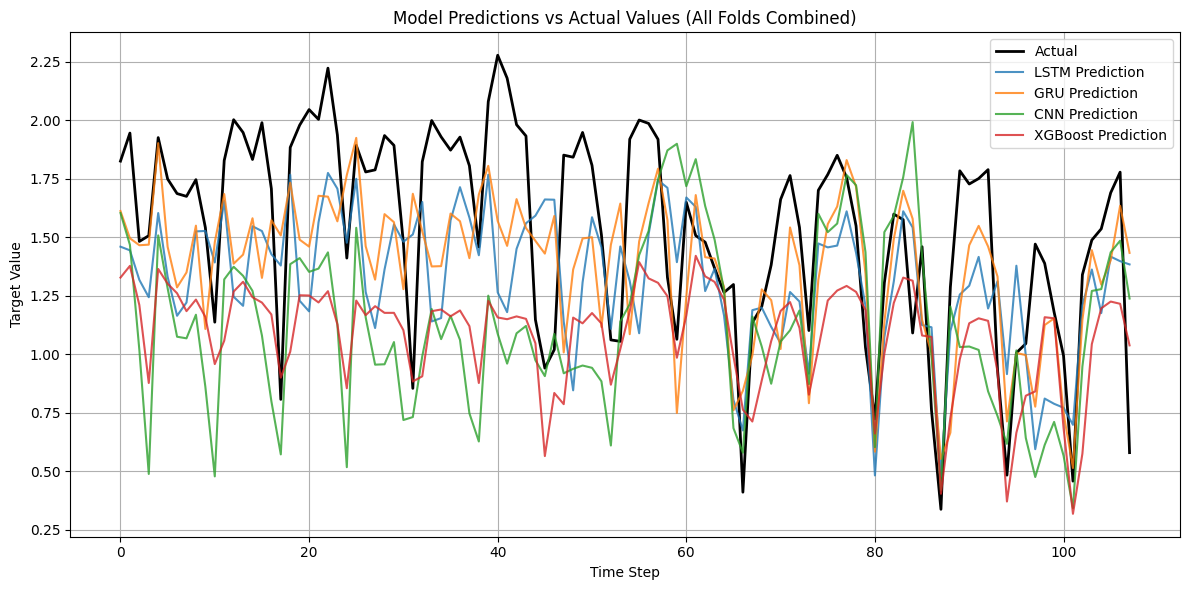

<Figure size 640x480 with 0 Axes>

In [ ]:
# CV loop for training
for i in range(FOLD_SZ):
    print(f'fold X {i+1} de treino: {X_train_folds[i].shape} e fold {i+1} X de teste: {X_test_folds[i].shape}')
    print(f'fold y {i+1} de treino: {y_train_folds[i].shape} e fold {i+1} y de teste: {y_test_folds[i].shape}')


    #Training the lstm net
    print(f' -------------------------------------- Treinando o fold {i+1} da rede LSTM -------------------------------------- ')
    lstm = build_lstm(X_train_folds[i].shape[1:], L_RATE)
    checkpoint = ModelCheckpoint(f'models/lstm_fold_{i+1}.weights.h5', save_weights_only=True, verbose = 1)
    lstm.fit(X_train_folds[i], y_train_folds[i], epochs=50, callbacks = checkpoint)

    #Training the gru net
    print(f' -------------------------------------- Treinando o fold {i+1} da rede GRU -------------------------------------- ')
    gru  = build_gru(  X_train_folds[i].shape[1:],L_RATE)
    checkpoint_gru = ModelCheckpoint(f'models/gru_fold_{i+1}.weights.h5', save_weights_only=True, verbose = 1)
    gru.fit(X_train_folds[i], y_train_folds[i], epochs=50, callbacks = checkpoint_gru)

    #Training the cnn net
    print(f' -------------------------------------- Treinando o fold {i+1} da rede CNN -------------------------------------- ')
    cnn  = build_cnn( X_train_folds[i].shape[1:],L_RATE)
    checkpoint_cnn = ModelCheckpoint(f'models/cnn_fold_{i+1}.weights.h5', save_weights_only=True, verbose = 1)
    cnn.fit(X_train_folds[i], y_train_folds[i], epochs=50, callbacks = checkpoint_cnn)

    #Training the xgboost net
    print(f' -------------------------------------- Treinando o fold {i+1} da rede XGB --------------------------------------')
    xgb_model = build_xgboost()  # renamed from xgb
    xgb_model.fit(
        X_train_folds[i].reshape(X_train_folds[i].shape[0], -1),
        y_train_folds[i].squeeze(),
        verbose=True
    )
    xgb_model.save_model(f'models/xbg_fold_{i+1}.json')

    #Saving the models
    lstm_trained.append(lstm)
    print(lstm_trained)

    gru_trained.append(gru)
    print(gru_trained)

    cnn_trained.append(cnn)
    print(cnn_trained)

    xgb_trained.append(xgb)
    print(xgb_trained)

    lstm_pred = lstm.predict(X_test_folds[i])
    gru_pred  = gru.predict(X_test_folds[i])
    cnn_pred  = cnn.predict(X_test_folds[i])
    xgb_pred  = xgb_model.predict(X_test_folds[i].reshape(X_test_folds[i].shape[0], -1))

    # Save predictions
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    cnn_preds.append(cnn_pred)
    xgb_preds.append(xgb_pred)

    # Calculate and print metrics
    y_true = y_test_folds[i].squeeze()
    print_metrics(y_true, lstm_pred.squeeze(), 'LSTM', i+1)
    print_metrics(y_true, gru_pred.squeeze(),  'GRU',  i+1)
    print_metrics(y_true, cnn_pred.squeeze(),  'CNN',  i+1)
    print_metrics(y_true, xgb_pred.squeeze(),  'XGBoost', i+1)

# Concatenate predictions and actual values from all folds
y_test_all = np.concatenate(y_test_folds).squeeze()
lstm_all   = np.concatenate(lstm_preds).squeeze()
gru_all    = np.concatenate(gru_preds).squeeze()
cnn_all    = np.concatenate(cnn_preds).squeeze()
xgb_all    = np.concatenate(xgb_preds).squeeze()

# Plot all predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_all[1400:], label='Actual', color='black', linewidth=2)
plt.plot(lstm_all[1400:], label='LSTM Prediction', alpha=0.8)
plt.plot(gru_all[1400:], label='GRU Prediction', alpha=0.8)
plt.plot(cnn_all[1400:], label='CNN Prediction', alpha=0.8)
plt.plot(xgb_all[1400:], label='XGBoost Prediction', alpha=0.8)

plt.title('Model Predictions vs Actual Values (All Folds Combined)')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
#training Meta Model
df_meta_model = pd.DataFrame({
    'xgb': xgb_all,
    'cnn': cnn_all,
    'gru': gru_all,
    'lstm': lstm_all,
    'actual':y_test_all
})

train = df_meta_model

predictors = train[['xgb','cnn','gru','lstm','actual']]
predicted = train[['actual']]

X_train, y_train = [], []
data_np = predictors.to_numpy()
pred_np = predicted.to_numpy()
for i in range(len(data_np) - LAGS_SZ - H_FORECAST + 1):
    X_train.append(data_np[i:i+LAGS_SZ])
    y_train.append(pred_np[i+LAGS_SZ:i+LAGS_SZ+H_FORECAST])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
y_train_flat = y_train.reshape(y_train.shape[0], -1)

rf = build_rf()
rf.fit(X_train_flat, y_train_flat.ravel()) 

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
#preprocess test data

#Z-Score Standarization
scaler = StandardScaler()
test_set['val_geracao_norm'] = scaler.fit_transform(test_set[['val_geracao']])
test_set['val_cargaenergiamwmed_norm'] = scaler.fit_transform(test_set[['val_cargaenergiamwmed']])
test_set['month_norm'] = scaler.fit_transform(test_set[['month']])
test_set['weekday_norm'] = scaler.fit_transform(test_set[['weekday']])

#defining dependent and idependent variables
test_predictors = test_set[['month_norm', 'weekday_norm', 'val_geracao_norm', 'val_cargaenergiamwmed_norm']]
test_predicted = test_predictors[['val_geracao_norm']]

#Creating Sequences
X_test_final, y_test_final = [], []
data_test_np = test_predictors.to_numpy()
pred_test_np = test_predicted.to_numpy()

for i in range(len(data_test_np) - LAGS_SZ - H_FORECAST + 1):
    X_test_final.append(data_test_np[i:i+LAGS_SZ])
    y_test_final.append(pred_test_np[i+LAGS_SZ:i+LAGS_SZ+H_FORECAST])

X_test_final = np.array(X_test_final)
y_test_final = np.array(y_test_final)

# # Rebuild and load weights
# lstm = build_lstm(X_test_final.shape[1:], L_RATE)
# gru = build_gru(X_test_final.shape[1:], L_RATE)
# cnn = build_cnn(X_test_final.shape[1:], L_RATE)
# xgb_model = build_xgboost()

lstm.load_weights('models/lstm_fold_2.weights.h5')
gru.load_weights('models/gru_fold_2.weights.h5')
cnn.load_weights('models/cnn_fold_2.weights.h5')
xgb_model.load_model('models/xbg_fold_2.json')

# Predict
y_pred_lstm = lstm.predict(X_test_final)
y_pred_gru  = gru.predict(X_test_final)
y_pred_cnn  = cnn.predict(X_test_final)
y_pred_xgb  = xgb_model.predict(X_test_final.reshape(X_test_final.shape[0], -1))


def print_metrics(y_true, y_pred, model_name, fold=None):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)


    fold_info = f" | Fold {fold}" if fold is not None else ""
    print(f"{model_name}{fold_info} -> MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}%")

print_metrics(y_test_final, y_pred_lstm, 'LSTM')
print_metrics(y_test_final, y_pred_gru,  'GRU')
print_metrics(y_test_final, y_pred_cnn,  'CNN')
print_metrics(y_test_final, y_pred_xgb,  'XGBoost')


C:\Users\mateu\AppData\Local\Temp\ipykernel_6572\2389031096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['val_geracao_norm'] = scaler.fit_transform(test_set[['val_geracao']])
C:\Users\mateu\AppData\Local\Temp\ipykernel_6572\2389031096.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['val_cargaenergiamwmed_norm'] = scaler.fit_transform(test_set[['val_cargaenergiamwmed']])
C:\Users\mateu\AppData\Local\Temp\ipykernel_6572\2389031096.py:7: SettingWithCopyWarning: 
A value is trying t

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM -> MSE: 0.3273 | RMSE: 0.5721 | MAPE: 3.03%
GRU -> MSE: 0.3357 | RMSE: 0.5794 | MAPE: 2.81%
CNN -> MSE: 0.3638 | RMSE: 0.6032 | MAPE: 2.99%
XGBoost -> MSE: 0.3789 | RMSE: 0.6156 | MAPE: 2.61%


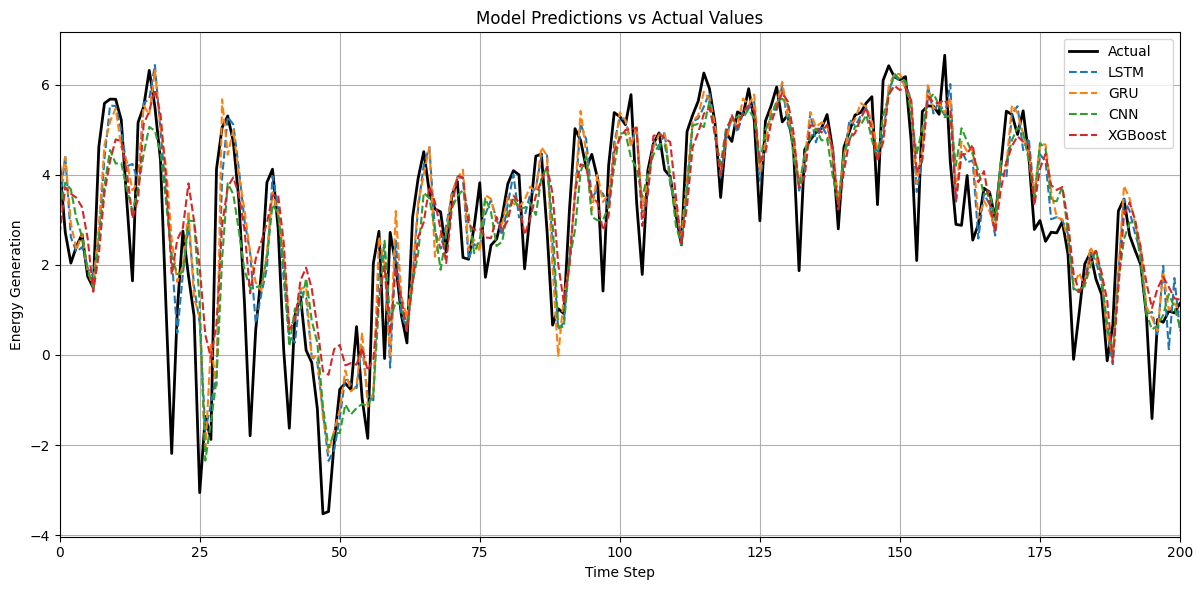

In [27]:
#Ploting data
y_true = y_test_final.reshape(-1)
y_lstm = y_pred_lstm.reshape(-1)
y_gru  = y_pred_gru.reshape(-1)
y_cnn  = y_pred_cnn.reshape(-1)
y_xgb  = y_pred_xgb.reshape(-1)

y_true_orig = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
y_lstm_orig = scaler.inverse_transform(y_lstm.reshape(-1, 1)).flatten()
y_gru_orig  = scaler.inverse_transform(y_gru.reshape(-1, 1)).flatten()
y_cnn_orig  = scaler.inverse_transform(y_cnn.reshape(-1, 1)).flatten()
y_xgb_orig  = scaler.inverse_transform(y_xgb.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))

plt.plot(y_true_orig, label='Actual', color='black', linewidth=2)
plt.plot(y_lstm_orig, label='LSTM', linestyle='--')
plt.plot(y_gru_orig, label='GRU', linestyle='--')
plt.plot(y_cnn_orig, label='CNN', linestyle='--')
plt.plot(y_xgb_orig, label='XGBoost', linestyle='--')

plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Energy Generation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 200)
plt.show()

In [28]:
#passing it to the rf meta model
y_pred_lstm = lstm.predict(X_test_final)       # shape: (samples, steps)
y_pred_gru  = gru.predict(X_test_final)
y_pred_cnn  = cnn.predict(X_test_final)
y_pred_xgb  = xgb_model.predict(X_test_final.reshape(X_test_final.shape[0], -1))  # shape: (samples,)

# Flatten each prediction if needed
lstm_preds_flat = y_pred_lstm.reshape(-1)
gru_preds_flat  = y_pred_gru.reshape(-1)
cnn_preds_flat  = y_pred_cnn.reshape(-1)
xgb_preds_flat  = y_pred_xgb.reshape(-1)
y_true_flat     = y_test_final.reshape(-1)

# Meta model input
df_meta_input = pd.DataFrame({
    'lstm': lstm_preds_flat,
    'gru': gru_preds_flat,
    'cnn': cnn_preds_flat,
    'xgb': xgb_preds_flat,
    'actual':  y_true_flat
})


predictors = df_meta_input[['xgb','cnn','gru','lstm','actual']]
predicted = df_meta_input[['actual']]

X_tst, y_tst = [], []
data_np = predictors.to_numpy()
pred_np = predicted.to_numpy()
for i in range(len(data_np) - LAGS_SZ - H_FORECAST + 1):
    X_tst.append(data_np[i:i+LAGS_SZ])
    y_tst.append(pred_np[i+LAGS_SZ:i+LAGS_SZ+H_FORECAST])

X_tst = np.array(X_tst)
y_tst = np.array(y_tst)

X_tst_flat = X_tst.reshape(X_tst.shape[0], -1)
y_tst_flat = y_tst.reshape(y_tst.shape[0], -1)

meta_pred = rf.predict(X_tst_flat)

y_true = y_tst_flat.reshape(-1)
y_pred = meta_pred.reshape(-1)

def print_metrics(y_true, y_pred, name='Model'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f'📊 Metrics for {name}:')
    print(f'  MSE:  {mse:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  MAPE: {mape:.4f}%')

print_metrics(y_true, y_pred, 'Random Forest Meta-Model')


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
📊 Metrics for Random Forest Meta-Model:
  MSE:  0.3842
  RMSE: 0.6199
  MAPE: 2.8509%


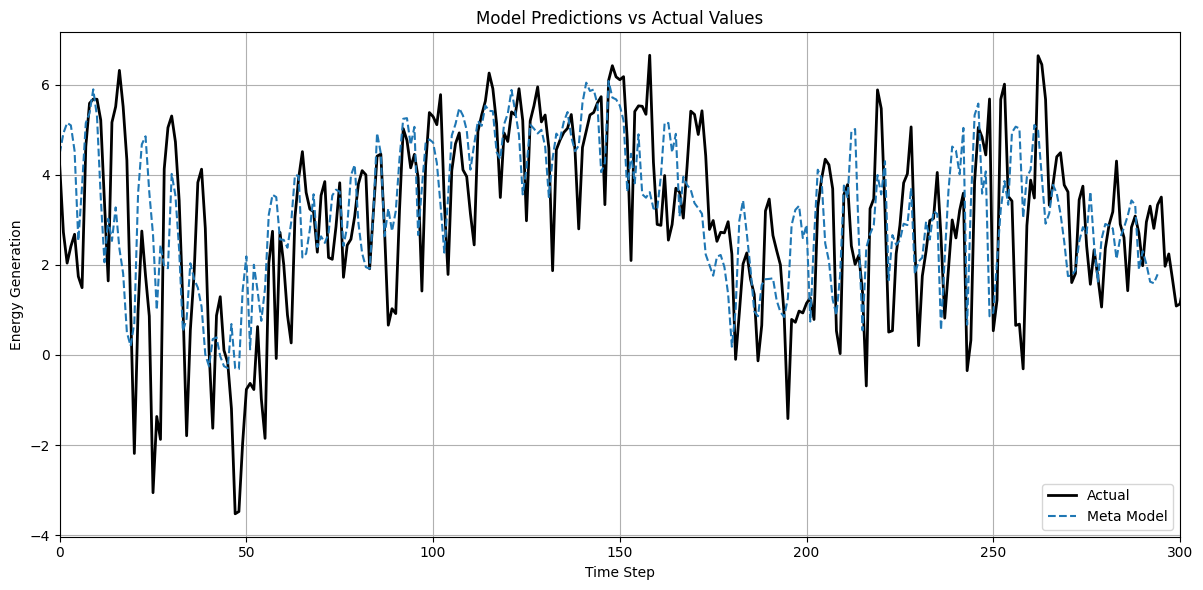

In [29]:
#Ploting data
y_true = y_test_final.reshape(-1)
meta_pred = meta_pred.reshape(-1)

y_true_orig = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
meta_pred = scaler.inverse_transform(meta_pred.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))

plt.plot(y_true_orig, label='Actual', color='black', linewidth=2)
plt.plot(meta_pred, label='Meta Model', linestyle='--')


plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Energy Generation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 300)
plt.show()